In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label
import skimage
from scipy.signal import correlate2d
import math

In [148]:
def auto_canny_edge_detection(image, sigma=0.33):
    # Edge Detection Algorithm, Not currently used
    md = np.mean(image)
    lower_value = int(max(0, (1.0-sigma) * md))
    upper_value = int(min(255, (1.0+sigma) * md))
    return cv2.Canny(image, lower_value, upper_value)

def crop_top(img,val,img_ori="portrait"):
    # Sets the black sides of the US image to a set value (should be 0 or 255)
    copy = img.copy()
    
    # for default portrait mode
    if img_ori == "portrait":
        image_width = 1350
        image_top_left = 555
        image_top_right = 785
        triangle_width_left = image_top_left
        triangle_width_right = image_width - image_top_right
        triangle_height_left = 845
        triangle_height_right = 870
        
    elif img_ori == "landscape":
        image_width = 1680
        image_top_left = 690
        image_top_right = 980
        triangle_width_left = image_top_left
        triangle_width_right = image_width - image_top_right
        triangle_height_left = 1050
        triangle_height_right = 1085
        
    else:
        raise ValueError("Invalid image orientation")
        
    for i in range(triangle_height_left):
        for j in range(int(image_top_left-(triangle_width_left/triangle_height_left)*i)):
            copy[i,j] = val
    for i in range(triangle_height_right):
        for j in range(int(image_top_right+(triangle_width_right/triangle_height_right)*i),img.shape[1]):
            copy[i,j] = val
    return copy

def crop_section(img_frame,section):
    '''
    Crops US image to contain only the segmented portion of the image

    Params:
    img_frame: image to be cropped
    section: section ID

    Returns:
    vertical_bounds: [Lower bound, Upper bound] vertical coordinates of image containing the section ID
    horizontal_bounds: [Lower bound, Upper bound] horizontal coordinates of image containing the section ID
    '''
    vertical_bounds = [img_frame.shape[0]-1,0]
    horizontal_bounds = [img_frame.shape[1]-1,0]
    for i in range(img_frame.shape[0]):
        if section in img_frame[i,:]:
            vertical_bounds[0] = min(vertical_bounds[0],i)
            vertical_bounds[1] = max(vertical_bounds[1],i)
    for j in range(img_frame.shape[1]):
        if section in img_frame[:,j]:
            horizontal_bounds[0] = min(horizontal_bounds[0],j)
            horizontal_bounds[1] = max(horizontal_bounds[1],j)
    return vertical_bounds, horizontal_bounds

def get_section_labels(img,img_ori,threshold=15):
    '''
    Returns array of images containing segmented sections of the image

    Params:
    img: Image to be segmented
    num_sections: Number of segmentations to output (Sections ordered by greatest number of pixels)
    binary: If True, outputs the image as a binary image determined by some intensity threshold (15)
    crop: If True, outputs only the segmentations; If False, outputs segments in whole image dimensions

    Returns:
    sections: Array of images containing num_sections segmentations
    '''
#     with_mean_img_blur = cv2.GaussianBlur(img, (5,5), 0)
    #img_blur = with_mean_img_blur-np.mean(with_mean_img_blur)

#     threshold = 25
#     binary_img = img - np.mean(img) < threshold
    
#     img -= cv2.GaussianBlur(img, (5,5), 0)
    mean_img = np.mean(img)
    no_dc_img = img - mean_img
    abs_no_dc_img = np.abs(no_dc_img) # show negative components
    # disable negative (non-real) components or show by adding (1) DC component or (2) 128 (mid-range of 0 to 255)
    DC_offsets = [0, mean_img, 128]
    DC_offset = DC_offsets[0]
    abs_no_dc_img[abs_no_dc_img >= 0] += DC_offset
    
    binary_img = no_dc_img < threshold
    binary_abs_no_dc_img = abs_no_dc_img < (threshold + DC_offset)

    labels_dark,numfeatures_dark = label(crop_top(binary_img,0,img_ori))
    labels_light,numfeatures_light = label(crop_top(np.logical_not(binary_img),0,img_ori))
    labels_all,numfeatures_all = labels_light + labels_dark, numfeatures_dark + numfeatures_light

    total = np.zeros(len(np.unique(labels_all)))
    for i,section in enumerate(np.unique(labels_all)):
        total[i] = np.sum(labels_all == section)

    hist,bins = np.histogram(total,bins = len(total))
    ordered_inds = np.flip(np.argsort(hist))

    features = np.flip(np.argsort(total))

    labels_copy = np.zeros(labels_all.shape, dtype=np.uint8)

    section_count = 1
    for section in features:
        if total[section] > bins[ordered_inds[1]]:
            labels_copy[labels_all == section] = section_count
            section_count += 1
        else:
            labels_copy[labels_all == section] = 0

    return labels_copy, no_dc_img, binary_img, abs_no_dc_img, binary_abs_no_dc_img

def get_sections(img,labels,binary = False,crop = True):
    num_labels = len(np.unique(labels))

    sections = []
    for section in range(1,num_labels):
        img_frame = labels.copy()
        if binary:
            seg_section = (img_frame == section)
        else:
            seg_section = img.copy()
            seg_section[img_frame != section] = 0
        if crop:
            vertical_bounds, horizontal_bounds = crop_section(img_frame,section)
            cropped_section = seg_section[vertical_bounds[0]:vertical_bounds[1],horizontal_bounds[0]:horizontal_bounds[1]]
        else:
            cropped_section = seg_section
        sections.append(cropped_section)
    return sections

def get_cmap(n, name='jet'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [151]:
def save_scan(plane, organ, scan_type):
    img = cv2.imread(f'images/{plane}_{organ}_{scan_type}.png',0)
    
    # default threshold is 15, change for certain scans
    threshold = 15
    # default image orientation is landscape, change for certain scans
    img_ori = "landscape"
    if plane == "transverse":
        if scan_type == "manual":
            img_ori = "portrait"
            if organ == "gallbladder":
                threshold = 5
            elif organ == "pancreas":
                threshold = 45
            elif organ == "right_kidney":
                threshold = 25
        elif scan_type == "haptic":
            if organ == "gallbladder":
                threshold = 25
            elif organ == "pancreas":
                threshold = 45
            elif organ == "right_kidney":
                threshold = 25
    elif plane == "sagittal":
        if scan_type != "auto":
            threshold = 25
            if scan_type == "manual":
                img_ori = "portrait"

    # threshold=25 # transverse gallbladder haptic
    labels, no_dc_img, binary_img, abs_no_dc_img, binary_abs_no_dc_img = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
    secs = get_sections(img,labels,binary = False,crop=False) # Get sections

    cmap = get_cmap(labels.max()+1)
    colors = np.zeros((labels.max()+1,3))
    for i in range(colors.shape[0]):
        colors[i] = cmap(i)[:3]

    # plot the colorized labels
    rgb_labels = colors[labels]

    fig1, ax1 = plt.subplots()
    ax1.imshow(img,'gray')
    ax1.axis('off')

    fig2, ax2 = plt.subplots()
    ax2.imshow(crop_top(rgb_labels,0,img_ori))
    ax2.axis('off')
    
    fig3, ax3 = plt.subplots()
    ax3.imshow(no_dc_img,'gray')
    ax3.axis('off')
    
    fig4, ax4 = plt.subplots()
    ax4.imshow(binary_img,'gray')
    ax4.axis('off')
    
    fig5, ax5 = plt.subplots()
    ax5.imshow(crop_top(abs_no_dc_img,0,img_ori),'gray')
    ax5.axis('off')
    
    fig6, ax6 = plt.subplots()
    ax6.imshow(binary_abs_no_dc_img,'gray')
    ax6.axis('off')

    dpi=600
#     fig1.savefig(f'images_segmented/{plane}_{organ}_{scan_type}_raw.png', dpi=dpi, bbox_inches='tight')
#     fig2.savefig(f'images_segmented/{plane}_{organ}_{scan_type}_segmented.png', dpi=dpi, bbox_inches='tight')
#     fig3.savefig(f'images_segmented/{plane}_{organ}_{scan_type}_no_dc.png', dpi=dpi, bbox_inches='tight')
#     fig4.savefig(f'images_segmented/{plane}_{organ}_{scan_type}_binary.png', dpi=dpi, bbox_inches='tight')
    fig5.savefig(f'images_segmented/{plane}_{organ}_{scan_type}_abs_no_dc.png', dpi=dpi, bbox_inches='tight')
    fig6.savefig(f'images_segmented/{plane}_{organ}_{scan_type}_binary_abs_no_dc.png', dpi=dpi, bbox_inches='tight')

#     plt.close(fig1)
#     plt.close(fig2)
#     plt.close(fig3)
#     plt.close(fig4)
#     plt.close(fig5)
#     plt.close(fig6)
    plt.show(fig1)
    plt.show(fig2)
    plt.show(fig3)
    plt.show(fig4)
    plt.show(fig5)
    plt.show(fig6)

transverse gallbladder manual


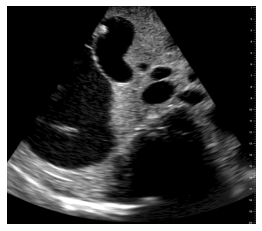

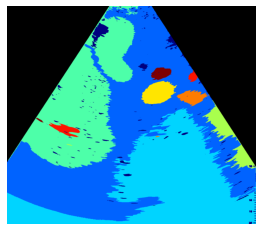

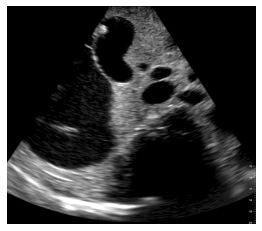

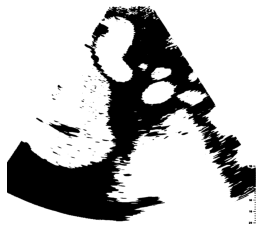

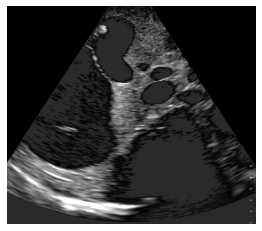

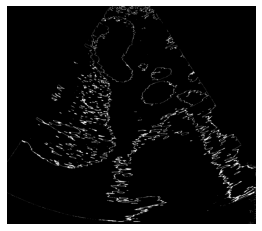

In [152]:
# Set correct path to desired US image
planes = ["transverse", "sagittal"]
organs = ["gallbladder", "pancreas", "pancreas_2", "right_kidney", "liver"]
scan_types = ["manual", "haptic"]
# scan_types = ["auto"]

# sagittal gallbladder scan
plane = planes[1]
organ = organs[0]
# for j, scan_type in enumerate(scan_types):
#     print(plane, organ, scan_type)
#     save_scan(plane, organ, scan_type)

# loop over transverse scans
plane = planes[0]
organs = ["gallbladder"]
scan_types = ["manual"]
for i, organ in enumerate(organs):
    for j, scan_type in enumerate(scan_types):
        print(plane, organ, scan_type)
        save_scan(plane, organ, scan_type)

In [48]:
img_ori = "portrait"
img = cv2.imread('images/transverse_gallbladder_manual.png',0)
threshold=5 # transverse gallbladder manual
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
# plot the colorized labels
rgb_labels = colors[labels]
# plt.imshow(crop_top(rgb_labels,0,img_ori))

fig, axs = plt.subplots(1, 2, sharey='row')
axs[0].imshow(img,'gray')
axs[1].imshow(crop_top(rgb_labels,0,img_ori))
axs[0].axis('off')
axs[1].axis('off')
plt.show()

AttributeError: 'tuple' object has no attribute 'copy'

In [ ]:
img_ori = "landscape"
img = cv2.imread('images/sagittal_gallbladder_haptic.png',0)
threshold=25
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

# plt.figure()
# plt.imshow(crop_top(skimage.color.label2rgb(labels,img),0,img_ori))
# plt.show()

print(labels.max())

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
    
# plot the colorized labels
rgb_labels = colors[labels]

# print(colors)
# print(labels.min())
# print(rgb_labels.shape)

fig, axs = plt.subplots(1, 2, sharey='row')
axs[0].imshow(img,'gray')
axs[1].imshow(crop_top(rgb_labels,0,img_ori))
axs[0].axis('off')
axs[1].axis('off')
# plt.savefig("test.png", bbox_inches='tight')
plt.show()

In [ ]:
img_ori = "portrait"
img = cv2.imread('images/sagittal_gallbladder_manual.png',0)
threshold=25
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
# plot the colorized labels
rgb_labels = colors[labels]
# plt.imshow(crop_top(rgb_labels,0,img_ori))

fig, axs = plt.subplots(1, 2, sharey='row')
axs[0].imshow(img,'gray')
axs[1].imshow(crop_top(rgb_labels,0,img_ori))
axs[0].axis('off')
axs[1].axis('off')
plt.show()

In [ ]:
img_ori = "landscape"
img = cv2.imread('images/transverse_right_kidney_haptic.png',0)
threshold=25
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
# plot the colorized labels
rgb_labels = colors[labels]
# plt.imshow(crop_top(rgb_labels,0,img_ori))

fig, axs = plt.subplots(1, 2, sharey='row')
axs[0].imshow(img,'gray')
axs[1].imshow(crop_top(rgb_labels,0,img_ori))
axs[0].axis('off')
axs[1].axis('off')
plt.show()

In [ ]:
img_ori = "portrait"
img = cv2.imread('images/transverse_right_kidney_manual.png',0)
threshold=25
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
# plot the colorized labels
rgb_labels = colors[labels]
# plt.imshow(crop_top(rgb_labels,0,img_ori))

fig, axs = plt.subplots(1, 2, sharey='row')
axs[0].imshow(img,'gray')
axs[1].imshow(crop_top(rgb_labels,0,img_ori))
axs[0].axis('off')
axs[1].axis('off')
plt.show()

In [ ]:
img_ori = "landscape"
img = cv2.imread('images/transverse_pancreas_2_haptic.png',0)
threshold=15
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
# plot the colorized labels
rgb_labels = colors[labels]
# plt.imshow(crop_top(rgb_labels,0,img_ori))

fig, axs = plt.subplots(1, 2, sharey='row')
axs[0].imshow(img,'gray')
axs[1].imshow(crop_top(rgb_labels,0,img_ori))
axs[0].axis('off')
axs[1].axis('off')
plt.show()

In [ ]:
img_ori = "portrait"
img = cv2.imread('images/transverse_pancreas_2_manual.png',0)
threshold=15
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
# plot the colorized labels
rgb_labels = colors[labels]
# plt.imshow(crop_top(rgb_labels,0,img_ori))

fig, axs = plt.subplots(1, 2, sharey='row')
axs[0].imshow(img,'gray')
axs[1].imshow(crop_top(rgb_labels,0,img_ori))
axs[0].axis('off')
axs[1].axis('off')
plt.show()

In [ ]:
img_ori = "landscape"
img = cv2.imread('images/transverse_liver_haptic.png',0)
threshold=15
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
# plot the colorized labels
rgb_labels = colors[labels]
# plt.imshow(crop_top(rgb_labels,0,img_ori))

fig, axs = plt.subplots(1, 2, sharey='row')
axs[0].imshow(img,'gray')
axs[1].imshow(crop_top(rgb_labels,0,img_ori))
axs[0].axis('off')
axs[1].axis('off')
plt.show()

In [ ]:
img_ori = "portrait"
img = cv2.imread('images/transverse_liver_manual.png',0)
threshold=15
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
# plot the colorized labels
rgb_labels = colors[labels]
# plt.imshow(crop_top(rgb_labels,0,img_ori))

fig, axs = plt.subplots(1, 2, sharey='row')
axs[0].imshow(img,'gray')
axs[1].imshow(crop_top(rgb_labels,0,img_ori))
axs[0].axis('off')
axs[1].axis('off')
plt.show()

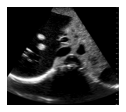

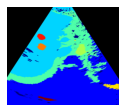

In [5]:
# Set correct path to desired US image
plane = "transverse"
organ = "pancreas"
img = cv2.imread(f'images/{plane}_{organ}_manual.png',0)
img_ori = "portrait"

threshold=45
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
# plot the colorized labels
rgb_labels = colors[labels]

fig1, ax1 = plt.subplots(figsize=(2,2))
ax1.imshow(img,'gray')
ax1.axis('off')

fig2, ax2 = plt.subplots(figsize=(2,2))
ax2.imshow(crop_top(rgb_labels,0,img_ori))
ax2.axis('off')

plt.show(fig1)
plt.show(fig2)

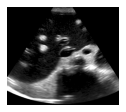

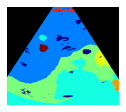

In [39]:
# Set correct path to desired US image
plane = "transverse"
organ = "pancreas"
img = cv2.imread(f'images/{plane}_{organ}_haptic.png',0)
img_ori = "landscape"

threshold=45
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
# plot the colorized labels
rgb_labels = colors[labels]

fig1, ax1 = plt.subplots(figsize=(2,2))
ax1.imshow(img,'gray')
ax1.axis('off')

fig2, ax2 = plt.subplots(figsize=(2,2))
ax2.imshow(crop_top(rgb_labels,0,img_ori))
ax2.axis('off')

plt.show(fig1)
plt.show(fig2)

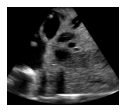

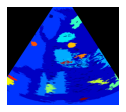

In [51]:
# Set correct path to desired US image
plane = "sagittal"
organ = "gallbladder"
img = cv2.imread(f'images/{plane}_{organ}_auto.png',0)
img_ori = "landscape"

threshold=15
labels = get_section_labels(crop_top(img,0,img_ori),img_ori,threshold)
secs = get_sections(img,labels,binary = False,crop=False) # Get sections

cmap = get_cmap(labels.max()+1)
colors = np.zeros((labels.max()+1,3))
for i in range(colors.shape[0]):
    colors[i] = cmap(i)[:3]
# plot the colorized labels
rgb_labels = colors[labels]

fig1, ax1 = plt.subplots(figsize=(2,2))
ax1.imshow(img,'gray')
ax1.axis('off')

fig2, ax2 = plt.subplots(figsize=(2,2))
ax2.imshow(crop_top(rgb_labels,0,img_ori))
ax2.axis('off')

plt.show(fig1)
plt.show(fig2)